## Preparation

In [0]:
# # TPU Setting
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'

# VERSION = "20200220"
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION


#### After pip install, need to restart the kernel.

In [2]:
!pip install numpy==1.16.4
!pip install pandas==0.25.0
!pip install torch==1.4.0
!pip install transformers
!pip install tqdm==4.43.0
!pip install scikit-plot

     |████████████████████████████████| 17.3MB 200kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


     |████████████████████████████████| 10.5MB 3.1MB/s 
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


     |████████████████████████████████| 501kB 3.3MB/s 
     |████████████████████████████████| 870kB 43.2MB/s 
     |████████████████████████████████| 3.7MB 56.9MB/s 
     |████████████████████████████████| 1.0MB 54.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=66af597a34ae179c4a74bd3c377e4696f4ed925f5d9b6fee1969e183142fbaf3
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
     |████████████████████████████████| 61kB 2.5MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from collections import defaultdict
from collections import Counter

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import scikitplot as skplt

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)

from transformers import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [0]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [6]:
# Check Device
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [8]:
# Colab version
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
# Load data
file = open('drive/My Drive/Colab Data/train_split_df.pickle', 'rb')
df = pickle.load(file)

file.close()

print(df.shape)
df.tail()

(2879, 10)


,date,rate,speaker,target,text,type,target_lower,target_hold,target_raise,word_count
2874,2019-08-23,2.0,Jerome Powell,0,until events quieted. The 10-year expansion we...,speech,1,0,0,190
2875,2019-08-23,2.0,Jerome Powell,0,out: Growth from the end of 2015 to the end of...,speech,1,0,0,194
2876,2019-10-07,2.0,Jerome Powell,1,"During World War II, the Fed effectively ceded...",speech,0,1,0,115
2877,2019-10-08,2.0,Jerome Powell,1,Our influence on the financial conditions that...,speech,0,1,0,204
2878,2019-10-08,2.0,Jerome Powell,1,the federal funds rate in the target range and...,speech,0,1,0,162


## Explore Data

1    1708
2     657
0     514
Name: target, dtype: int64
1    0.593262
2    0.228204
0    0.178534
Name: target, dtype: float64


Text(0, 0.5, 'number of samples')

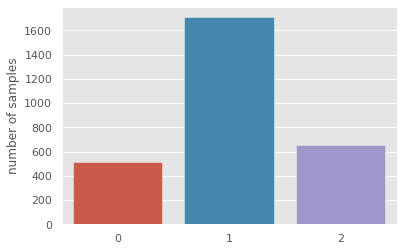

In [10]:
# The number of data per Target Labels
x = df.target.value_counts()
print(x)
print(x/sum(x))
sns.barplot(x.index, x)
plt.gca().set_ylabel('number of samples')

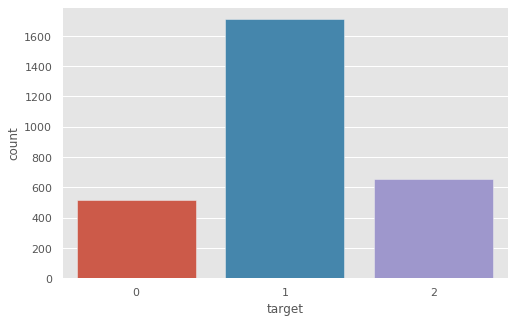

In [11]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='target', data=df)

In [0]:
# Corpus
def create_corpus(target):
    corpus = []
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Returns Top X frequent words
def get_frequent_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

Text(0.5, 1.0, 'Raise')

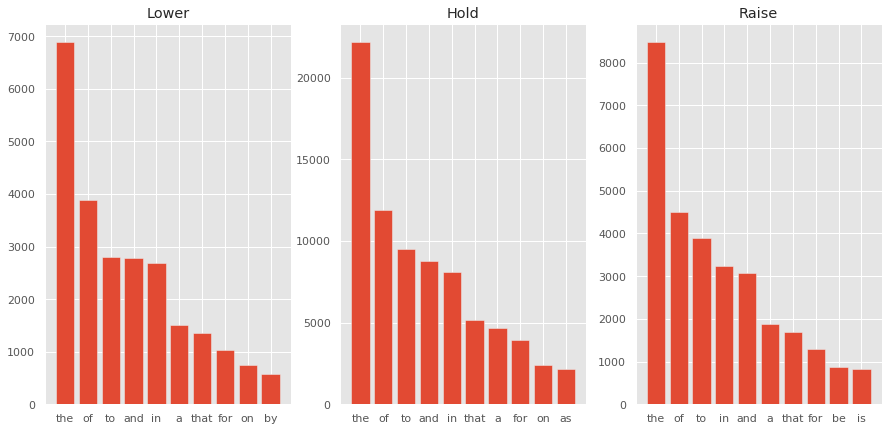

In [13]:
# Most frequent words
corpus_lower = create_corpus(0)
corpus_hold = create_corpus(1)
corpus_raise = create_corpus(2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
x, y = get_frequent_words(corpus_lower)
ax1.bar(x, y)
ax1.set_title('Lower')
x, y = get_frequent_words(corpus_hold)
ax2.bar(x, y)
ax2.set_title('Hold')
x, y = get_frequent_words(corpus_raise)
ax3.bar(x, y)
ax3.set_title('Raise')

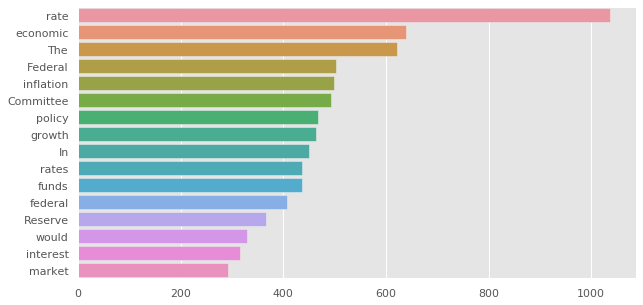

In [14]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus_lower)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Speech')

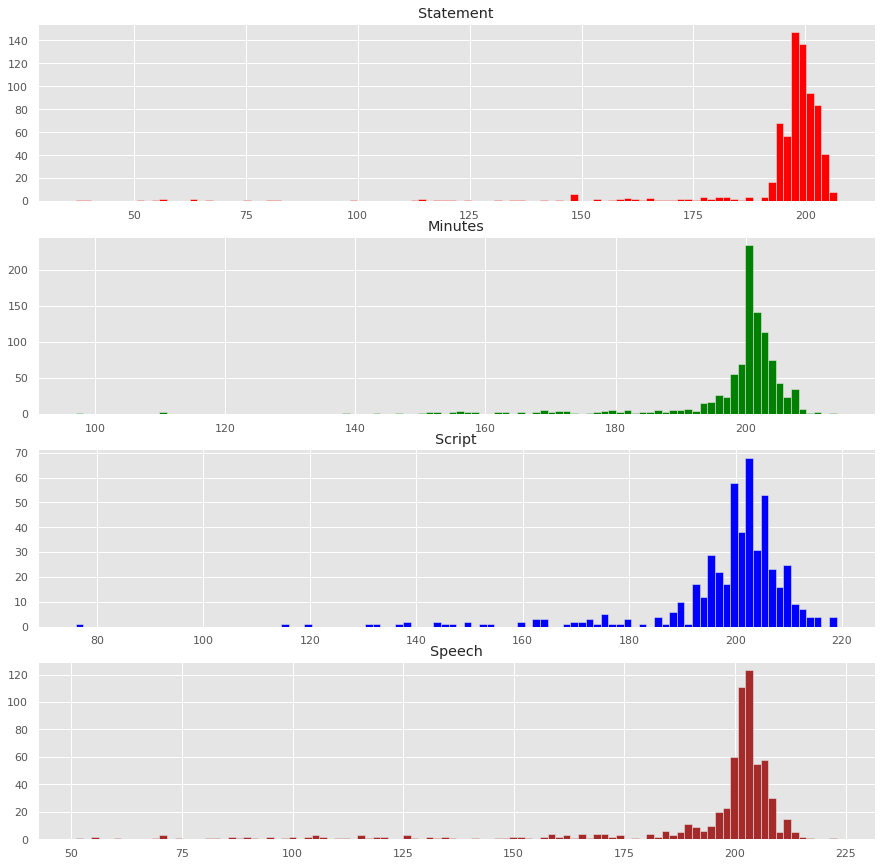

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
contents_len = df[df['type'] == 'statement']['word_count']
ax1.hist(contents_len, color='red', bins=100)
ax1.set_title('Statement')
contents_len = df[df['type'] == 'minutes']['word_count']
ax2.hist(contents_len, color='green', bins=100)
ax2.set_title('Minutes')
contents_len = df[df['type'] =='script']['word_count']
ax3.hist(contents_len, color='blue', bins=100)
ax3.set_title('Script')
contents_len = df[df['type'] =='speech']['word_count']
ax4.hist(contents_len, color='brown', bins=100)
ax4.set_title('Speech')


In [16]:
len(df[df['word_count'] > 300])

0

## Define Train DataFrame

In [40]:
#train_df = df # All data
train_df = df.loc[df['type'].isin(['statement'])]
#train_df = df.loc[df['type'].isin(['statement', 'minutes', 'script'])]
#train_df = df.loc[df['speaker']=='Ben Bernanke']

print(train_df.shape)
train_df.reset_index(inplace=True)
train_df

(731, 10)


,index,date,rate,speaker,target,text,type,target_lower,target_hold,target_raise,word_count
0,0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that t...,statement,0,0,1,99
1,1,1994-03-22,3.50,Alan Greenspan,2,Chairman Alan Greenspan announced today that t...,statement,0,0,1,40
2,2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that t...,statement,0,0,1,37
3,3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board appro...",statement,0,0,1,57
4,4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board ...",statement,0,0,1,51
...,...,...,...,...,...,...,...,...,...,...,...
726,726,2019-10-11,2.00,Jerome Powell,1,market pressures that could adversely affect p...,statement,0,1,0,190
727,727,2019-10-30,1.75,Jerome Powell,0,Information received since the Federal Open Ma...,statement,1,0,0,199
728,728,2019-10-30,1.75,Jerome Powell,0,This action supports the Committee's view that...,statement,1,0,0,194
729,729,2019-12-11,1.75,Jerome Powell,1,Information received since the Federal Open Ma...,statement,0,1,0,199


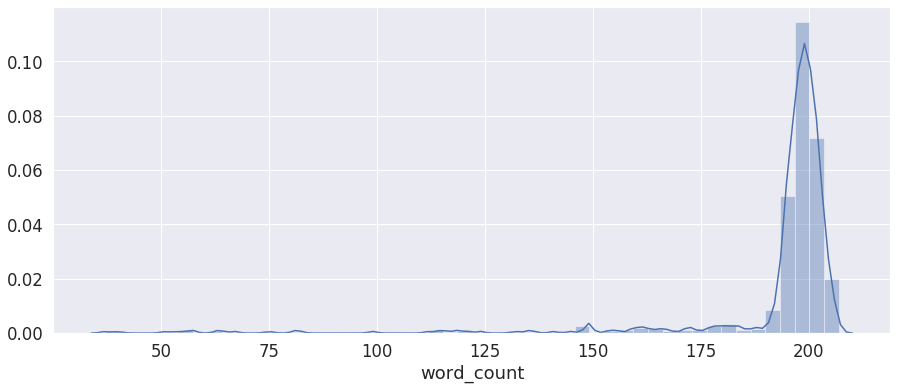

In [41]:
sns.distplot(train_df['word_count'])

## Model

In [0]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=512):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [0]:
# Prepare training data
train_set = []
max_seq_length = 200

for index, row in train_df.iterrows():
    input_ids, masks, segments = bert_encoder(row.text, max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row.target)))


train_labels = train_df['target'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

In [0]:
# Complex Model by adding 5 horizontal dropout layers (multi-sample dropout)
class MultiSampleDropoutModel(nn.Module):
    def __init__(self, hidden_size=768, num_class=3):
        super(MultiSampleDropoutModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, input_ids, input_mask, segment_ids):
        all_hidden_states, all_attentions = self.bert(input_ids, token_type_ids=segment_ids,
                                                                attention_mask=input_mask)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                h = self.fc(dropout(feature))
            else:
                h += self.fc(dropout(feature))
        h = h / len(self.dropouts)
        return h  

In [0]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 4
batch_size = 8
patience =2
file_name = 'model'

In [0]:
# Define metrics
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

In [48]:
print(train_valid_labels)

[2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 0 0 0 0 0 0 0 1 1 0 

In [0]:
# for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
#   print('fold: ', fold)
#   print('train_indices', train_indices)
#   print ('valid_indices', valid_indices)

In [50]:
# Test Tokenizer

from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)

loss, logits = outputs[:2]

print('input_ids: ',input_ids)
print('labels: ', labels)
print('outputs: ',outputs[:2])

input_ids:  tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
labels:  tensor([[1]])
outputs:  (tensor(0.9375, grad_fn=<NllLossBackward>), tensor([[0.5026, 0.0620]], grad_fn=<AddmmBackward>))


## Train

### Function for training

In [0]:
def train_bert(fold, train_indices, valid_indices):
    
    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False
    )
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    # Set Train Mode
    model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader)):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch
            
            # Feedforward prediction
            # y_pred = model(x_ids, x_mask, x_sids)

            # Calculate Loss
            #loss = loss_fn(y_pred, y_truth)
            
            output = model(x_ids, labels=y_truth)
            loss, logit = output[:2]
            #print("loss: ", loss)
            #print("logit: ", logit)
            
            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)
            
            #logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        # Move to Evaluation Mode
        model.eval()
        
        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader)):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                out = model(x_ids)
                y_pred = out[0].detach()
                #print(y_pred)
                val_loss += loss_fn(y_pred, y_truth).item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                # print('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(model.state_dict(), 'model_fold_{}.bin'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break
            
        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    # Load the best model
    model.load_state_dict(torch.load('model_fold_{}.bin'.format(fold)))
    # Set Evaluation Mode
    model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader)):
            batch = tuple(t.cuda() for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            out = model(x_ids)
            y_pred = out[0].detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()


    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
      disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

In [0]:
use_skf = True

[2020-03-04 19:41:37,656][INFO] ## ================     fold 0        ===============


[2020-03-04 19:41:56,960][INFO] ## epoch: 0, train loss: 0.97826884, valid loss: 0.96271979, acc: 0.63809524, f1: 0.45722768, best_f1: 0.45722768



[2020-03-04 19:42:13,186][INFO] ## epoch: 1, train loss: 0.81297280, valid loss: 0.88295541, acc: 0.67619048, f1: 0.53120448, best_f1: 0.53120448



[2020-03-04 19:42:29,437][INFO] ## epoch: 2, train loss: 0.66764257, valid loss: 0.77459110, acc: 0.72380952, f1: 0.60701258, best_f1: 0.60701258



[2020-03-04 19:42:45,593][INFO] ## epoch: 3, train loss: 0.58205026, valid loss: 0.71083868, acc: 0.73333333, f1: 0.67196637, best_f1: 0.67196637



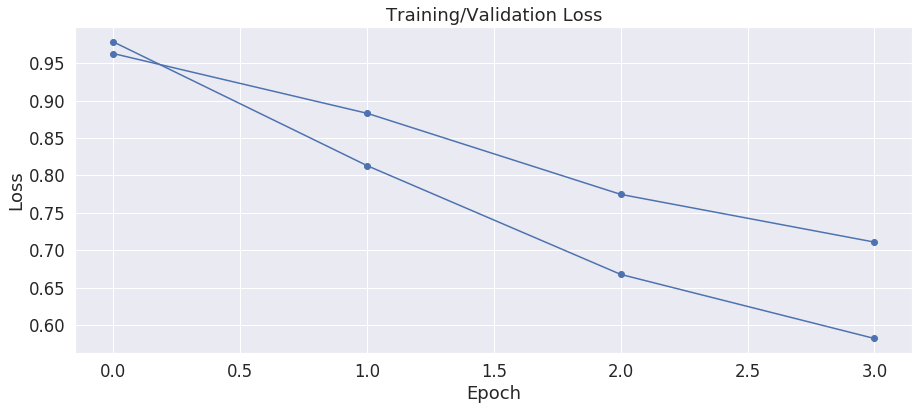

[2020-03-04 19:42:47,192][INFO] ## epoch: best, acc: 0.73333333, f1: 0.67196637, best_f1: 0.67196637



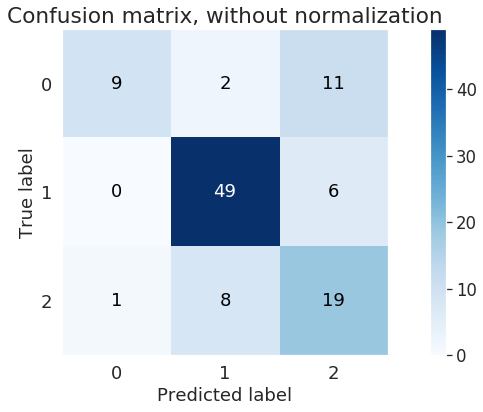

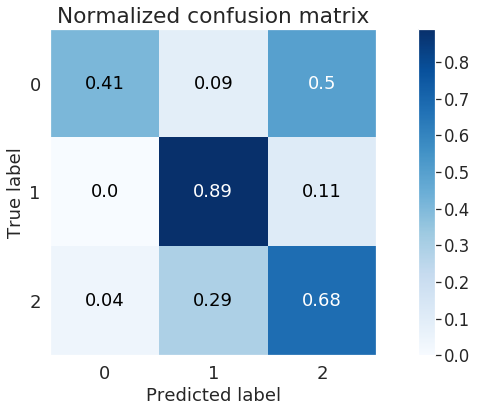

[2020-03-04 19:42:47,750][INFO] ## ================     fold 1        ===============


[2020-03-04 19:43:06,692][INFO] ## epoch: 0, train loss: 1.03161609, valid loss: 0.82258705, acc: 0.61904762, f1: 0.42543713, best_f1: 0.42543713



[2020-03-04 19:43:22,896][INFO] ## epoch: 1, train loss: 0.75213446, valid loss: 0.54181502, acc: 0.80000000, f1: 0.68979232, best_f1: 0.68979232



[2020-03-04 19:43:39,242][INFO] ## epoch: 2, train loss: 0.54129330, valid loss: 0.50873165, acc: 0.79047619, f1: 0.76885765, best_f1: 0.76885765



[2020-03-04 19:43:55,426][INFO] ## epoch: 3, train loss: 0.42241078, valid loss: 0.32650868, acc: 0.88571429, f1: 0.86403826, best_f1: 0.86403826



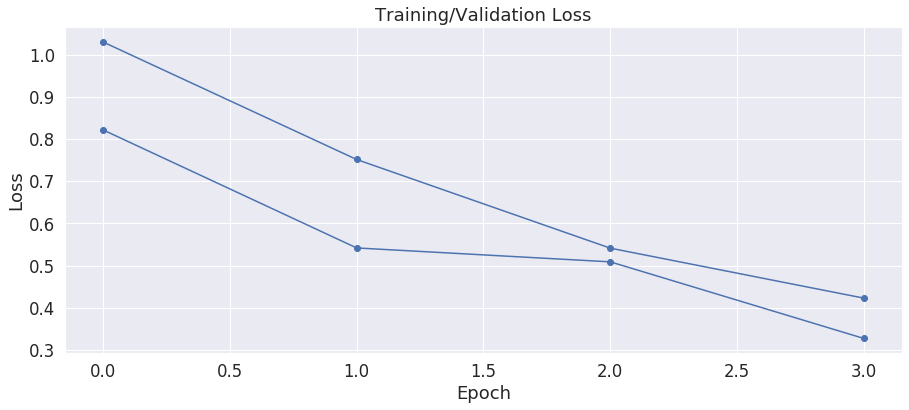

[2020-03-04 19:43:57,051][INFO] ## epoch: best, acc: 0.88571429, f1: 0.86403826, best_f1: 0.86403826



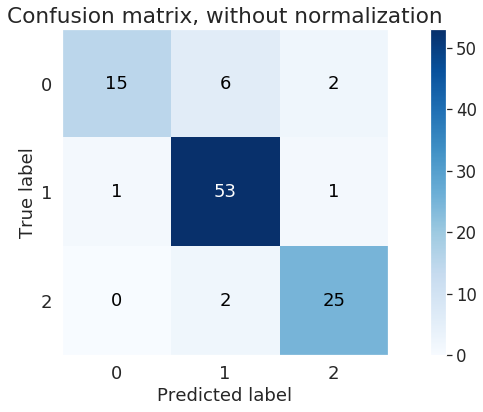

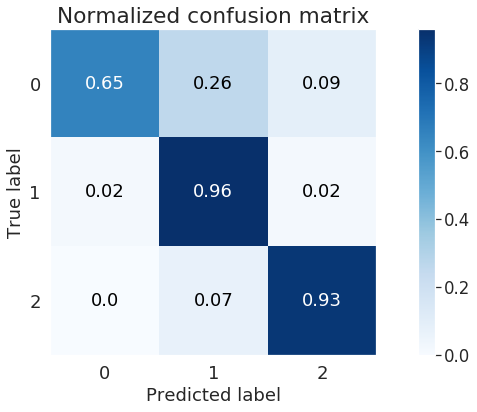

[2020-03-04 19:43:57,605][INFO] ## ================     fold 2        ===============


[2020-03-04 19:44:16,884][INFO] ## epoch: 0, train loss: 0.95825494, valid loss: 0.86736185, acc: 0.76190476, f1: 0.71455807, best_f1: 0.71455807



[2020-03-04 19:44:32,914][INFO] ## epoch: 1, train loss: 0.66212050, valid loss: 0.65130716, acc: 0.85714286, f1: 0.81984127, best_f1: 0.81984127



[2020-03-04 19:44:49,159][INFO] ## epoch: 2, train loss: 0.47497888, valid loss: 0.55521080, acc: 0.86666667, f1: 0.85334153, best_f1: 0.85334153



[2020-03-04 19:45:05,415][INFO] ## epoch: 3, train loss: 0.37699523, valid loss: 0.42071240, acc: 0.87619048, f1: 0.85492602, best_f1: 0.85492602



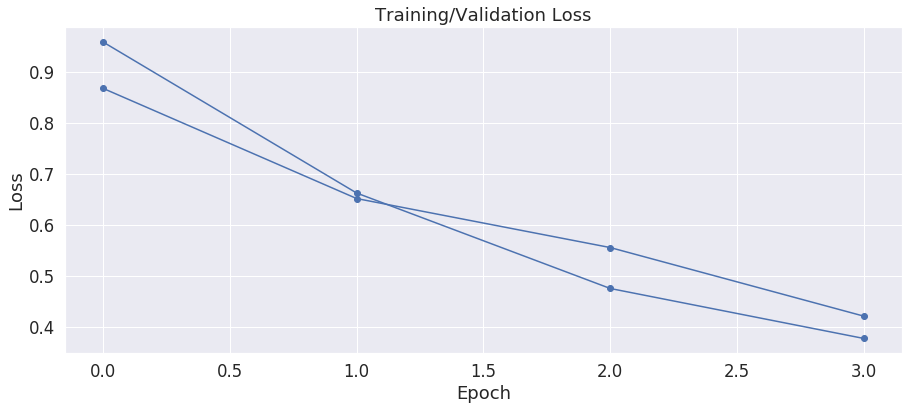

[2020-03-04 19:45:07,100][INFO] ## epoch: best, acc: 0.87619048, f1: 0.85492602, best_f1: 0.85492602



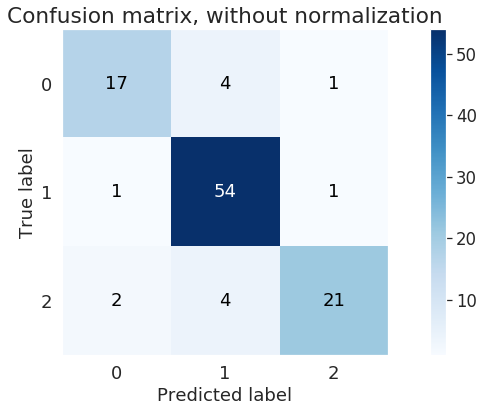

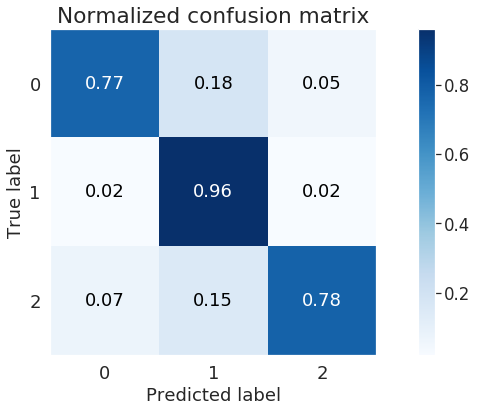

[2020-03-04 19:45:07,634][INFO] ## ================     fold 3        ===============


[2020-03-04 19:45:26,915][INFO] ## epoch: 0, train loss: 0.93111671, valid loss: 0.92548654, acc: 0.53846154, f1: 0.39931711, best_f1: 0.39931711



[2020-03-04 19:45:43,498][INFO] ## epoch: 1, train loss: 0.72873224, valid loss: 0.69358075, acc: 0.75961538, f1: 0.70578603, best_f1: 0.70578603



[2020-03-04 19:45:59,556][INFO] ## epoch: 2, train loss: 0.57352068, valid loss: 0.58058088, acc: 0.78846154, f1: 0.74622403, best_f1: 0.74622403



[2020-03-04 19:46:15,829][INFO] ## epoch: 3, train loss: 0.40692939, valid loss: 0.46131288, acc: 0.84615385, f1: 0.82927366, best_f1: 0.82927366



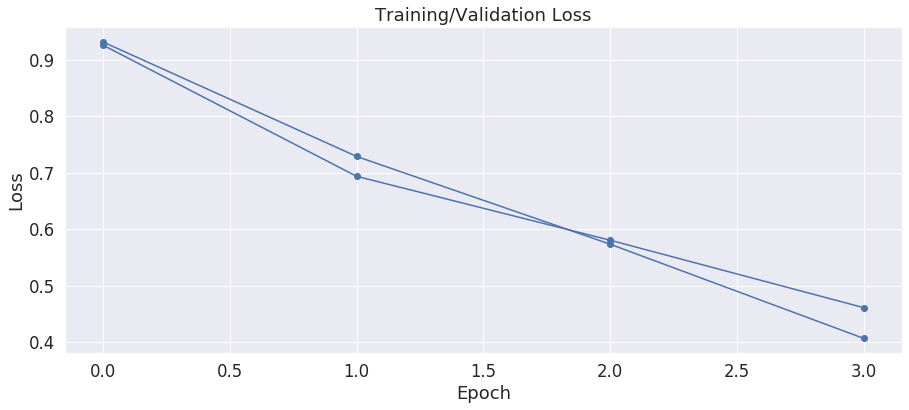

[2020-03-04 19:46:17,544][INFO] ## epoch: best, acc: 0.84615385, f1: 0.82927366, best_f1: 0.82927366



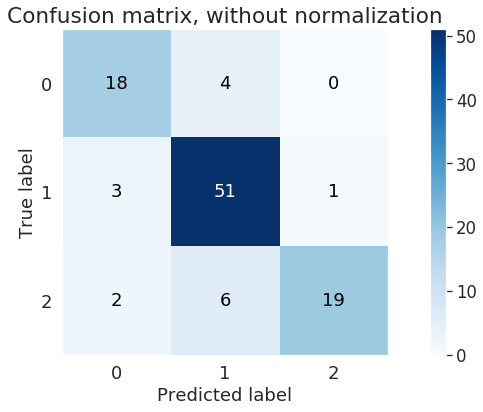

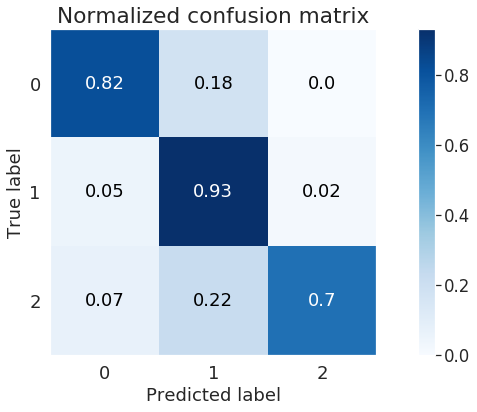

[2020-03-04 19:46:18,066][INFO] ## ================     fold 4        ===============


[2020-03-04 19:46:36,964][INFO] ## epoch: 0, train loss: 0.98991286, valid loss: 0.88939785, acc: 0.62500000, f1: 0.46758563, best_f1: 0.46758563



[2020-03-04 19:46:53,466][INFO] ## epoch: 1, train loss: 0.78704126, valid loss: 0.75580367, acc: 0.70192308, f1: 0.61438469, best_f1: 0.61438469



[2020-03-04 19:47:09,584][INFO] ## epoch: 2, train loss: 0.60886465, valid loss: 0.52222063, acc: 0.82692308, f1: 0.76816428, best_f1: 0.76816428



[2020-03-04 19:47:25,761][INFO] ## epoch: 3, train loss: 0.43606931, valid loss: 0.39202353, acc: 0.87500000, f1: 0.85208458, best_f1: 0.85208458



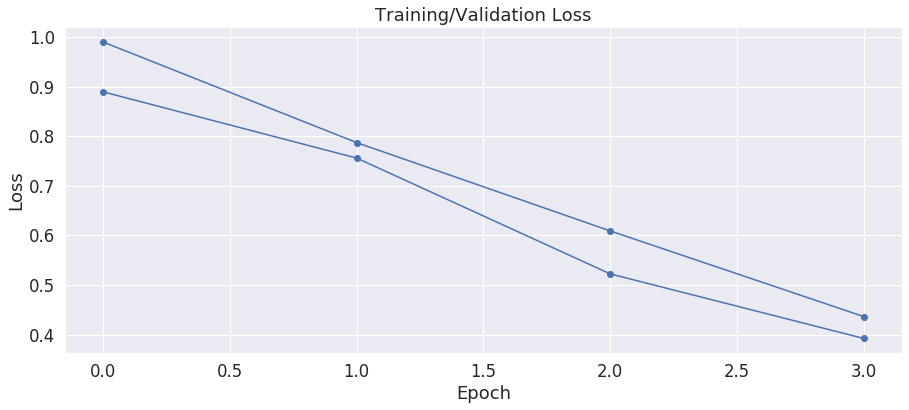

[2020-03-04 19:47:27,247][INFO] ## epoch: best, acc: 0.87500000, f1: 0.85208458, best_f1: 0.85208458



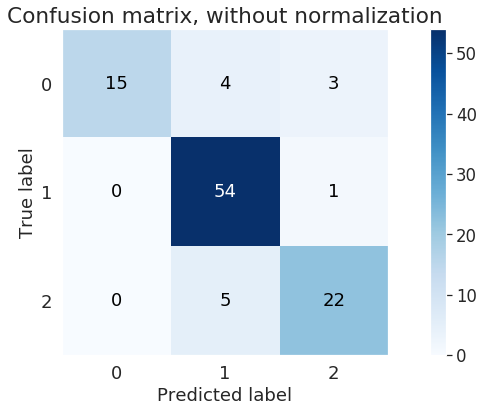

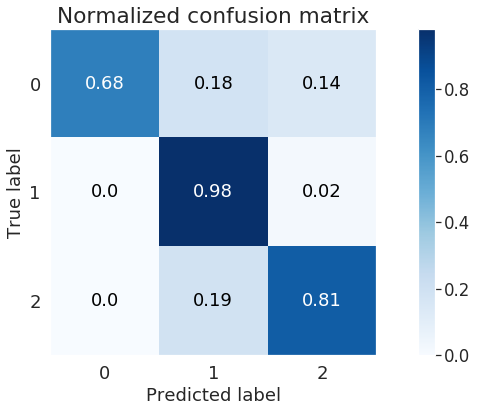

[2020-03-04 19:47:27,747][INFO] ## ================     fold 5        ===============


[2020-03-04 19:47:46,754][INFO] ## epoch: 0, train loss: 0.91800305, valid loss: 0.74557203, acc: 0.79807692, f1: 0.75599174, best_f1: 0.75599174



[2020-03-04 19:48:02,986][INFO] ## epoch: 1, train loss: 0.58784635, valid loss: 0.62609009, acc: 0.79807692, f1: 0.76927073, best_f1: 0.76927073



[2020-03-04 19:48:18,034][INFO] ## epoch: 2, train loss: 0.41641337, valid loss: 0.59864962, acc: 0.77884615, f1: 0.75222417, best_f1: 0.76927073



[2020-03-04 19:48:33,023][INFO] ## epoch: 3, train loss: 0.33164713, valid loss: 0.54627222, acc: 0.79807692, f1: 0.76927073, best_f1: 0.76927073



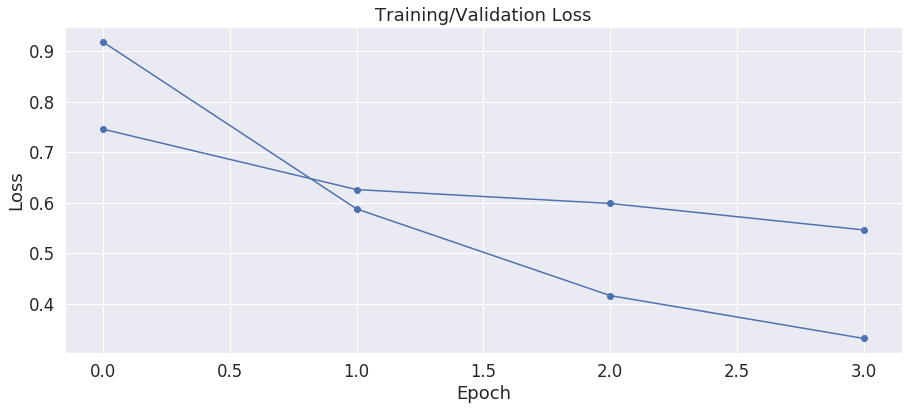

[2020-03-04 19:48:34,472][INFO] ## epoch: best, acc: 0.79807692, f1: 0.76927073, best_f1: 0.76927073



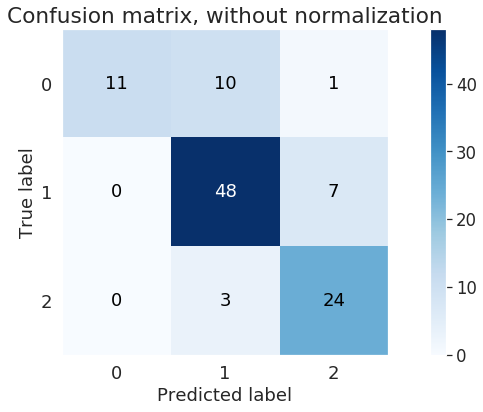

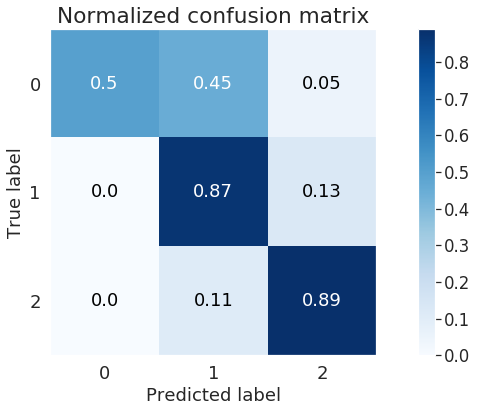

[2020-03-04 19:48:34,978][INFO] ## ================     fold 6        ===============


[2020-03-04 19:48:54,033][INFO] ## epoch: 0, train loss: 0.90707978, valid loss: 0.80524212, acc: 0.66346154, f1: 0.48405797, best_f1: 0.48405797



[2020-03-04 19:49:10,234][INFO] ## epoch: 1, train loss: 0.74962332, valid loss: 0.69279764, acc: 0.68269231, f1: 0.54912204, best_f1: 0.54912204



[2020-03-04 19:49:26,404][INFO] ## epoch: 2, train loss: 0.61261009, valid loss: 0.66393788, acc: 0.78846154, f1: 0.76337541, best_f1: 0.76337541



[2020-03-04 19:49:42,350][INFO] ## epoch: 3, train loss: 0.46064307, valid loss: 0.42100110, acc: 0.87500000, f1: 0.85605022, best_f1: 0.85605022



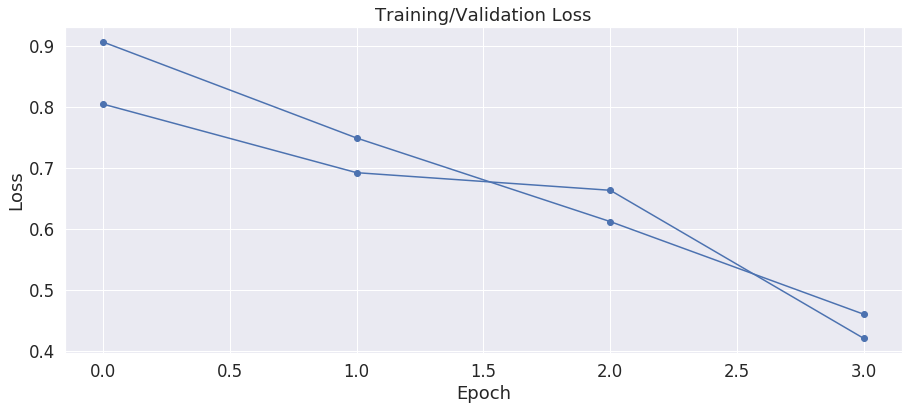

[2020-03-04 19:49:43,822][INFO] ## epoch: best, acc: 0.87500000, f1: 0.85605022, best_f1: 0.85605022



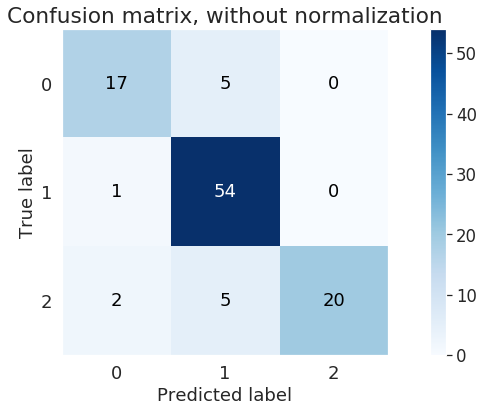

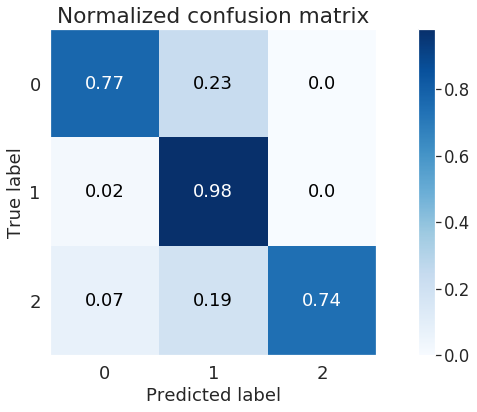

In [55]:
if use_skf:
  skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
  
  for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
    train_bert(fold, train_indices, valid_indices)

else:
  train_ratio = 0.7
  train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
  valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

  train_bert(0, train_indices, valid_indices)
  # print('train_indices', train_indices)
  # print('valid_indices', valid_indices)


In [56]:
oof_train

array([[0.11705746, 0.4161544 , 0.4667881 ],
       [0.08787941, 0.48214558, 0.42997494],
       [0.16157673, 0.32077202, 0.51765126],
       ...,
       [0.31718254, 0.5861058 , 0.0967116 ],
       [0.0391094 , 0.8652106 , 0.09567992],
       [0.10365316, 0.79214305, 0.10420378]], dtype=float32)

In [57]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
train_df['pred_target'] = np.argmax(oof_train, axis=1)
train_df['pred_target_lower'] = oof_train[:,0]
train_df['pred_target_hold'] = oof_train[:,1]
train_df['pred_target_raise'] = oof_train[:,2]
train_df.head()

[2020-03-04 19:51:28,939][INFO] ## 0.8147241488734757
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,index,date,rate,speaker,target,text,type,target_lower,target_hold,target_raise,word_count,pred_target,pred_target_lower,pred_target_hold,pred_target_raise
0,0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that t...,statement,0,0,1,99,2,0.117057,0.416154,0.466788
1,1,1994-03-22,3.50,Alan Greenspan,2,Chairman Alan Greenspan announced today that t...,statement,0,0,1,40,1,0.087879,0.482146,0.429975
2,2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that t...,statement,0,0,1,37,2,0.161577,0.320772,0.517651
3,3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board appro...",statement,0,0,1,57,2,0.139274,0.393462,0.467263
4,4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board ...",statement,0,0,1,51,2,0.380958,0.036457,0.582585


In [0]:
# Save results to Drive
file = open('drive/My Drive/Colab Data/statement_trained_df.pickle', 'wb')
pickle.dump(train_df, file)
file.close()

train_df.to_csv('drive/My Drive/Colab Data/statement_trained_df.csv', index=False)